Los objetivos de este análisis son:
* Identificar el tipo de dato de todas la entidades en la tabla.
* Estadísticas generales (conteo de registros, mínimo, máximo, datos nulos, etc.)
* Conocer la longitud máxima de cadena para cada entidad.
* Identificar y corregir problemas en los datos.
* Identificar llaves primarias y foráneas.

In [1]:
# Librerías
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

* Se encontró el mensaje: "Error tokenizing data. C error: Expected 29 fields in line 244, saw 30" al leer los datos como un DataFrame para CUSTOMERt, PRODUCTSt y PROMOTION. Esto se debe a que hay filas con mayor cantidad de datos que los encabezados de columna.
* Al revisar los datos en CSV, existen descripciones que emplean comas(,). Se procedió a reemplazar los casos ", " por ("; ").
* Adicionalmente, PRODUCTSt en la línea en el Product Key 477 hacía uso de una coma para indicar decimales y se reemplazó "0," por "0.".

In [2]:
# myPath = '/workspaces/Database-project/data/aligned/'
# # CUSTOMERS
# custFile = open(myPath + "CUSTOMERt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in custFile]) \
#     .replace(", ", "; ")
# x = open(myPath + "CUSTOMERt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PRODUCTS
# prodFile = open(myPath + "PRODUCTSt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prodFile]) \
#     .replace(", ", "; ").replace("0,", "0.")
# x = open(myPath + "PRODUCTSt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PROMOTION
# prom_file = open(myPath + "PROMOTION.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prom_file]) \
#     .replace(", ", "; ")
# x = open(myPath + "PROMOTION_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()

# Lectura de datos
myPath = '/workspaces/Database-project/data/'
# Principales
sales = pd.read_csv(myPath + 'SALES.csv', encoding='latin-1')
cust = pd.read_csv(myPath + 'aligned/CUSTOMERt_aligned.csv', encoding='latin-1')
prod = pd.read_csv(myPath + 'aligned/PRODUCTSt_aligned.csv', encoding='latin-1')
# Complementarios
prom = pd.read_csv(myPath + 'aligned/PROMOTION_aligned.csv', encoding='latin-1')
curr = pd.read_csv(myPath + 'CURRENCY.csv', encoding='latin-1')


## 1. Sales
Preguntas planteadas al tener una visualización general:
1. ¿Son útiles las columnas OrderDateKey, ShipDateKey y CustomerKey?
2. ¿Son nulos todos los datos en CarrierTrackingNumber y CustomerPONumber?
3. ¿Cuál es la función del identificador SalesOrderNumber?
4. ¿Existen registros nulos en alguna otra columna?
5. ¿SalesTerritoryKey es llave primaria de otra tabla?

In [3]:
# sales.info() # 60398 entries, 26 columns
sales.head(3)

ProductKey  OrderDateKey  DueDateKey  ShipDateKey  CustomerKey  \
0         310      20101229    20110110     20110105        21768   
1         346      20101229    20110110     20110105        28389   
2         346      20101229    20110110     20110105        25863   

   PromotionKey  CurrencyKey  SalesTerritoryKey SalesOrderNumber  \
0             1           19                  6          SO43697   
1             1           39                  7          SO43698   
2             1          100                  1          SO43699   

   SalesOrderLineNumber  ...  ProductStandardCost  TotalProductCost  \
0                     1  ...            2171.2942         2171.2942   
1                     1  ...            1912.1544         1912.1544   
2                     1  ...            1912.1544         1912.1544   

   SalesAmount    TaxAmt  Freight  CarrierTrackingNumber  CustomerPONumber  \
0      3578.27  286.2616  89.4568                    NaN               NaN   
1      3399.99  271.9992  84.9998                    NaN               NaN   
2      3399.99  271.9992  84.9998                    NaN               NaN   

             OrderDate              DueDate             ShipDate  
0  2010-12-29 00:00:00  2011-01-10 00:00:00  2011-01-05 00:00:00  
1  2010-12-29 00:00:00  2011-01-10 00:00:00  2011-01-05 00:00:00  
2  2010-12-29 00:00:00  2011-01-10 00:00:00  2011-01-05 00:00:00  

[3 rows x 26 columns]

### Modificaciones en la tabla sales
* SalesOrderNumber contiene una cantidad de registros mucho menor y se concluye que es de utilidad para realizar agrupaciones.
* Se eliminan las columnas sin datos (CarrierTrackingNumber, CustomerPONumber) y las "llaves" de fechas (YYYYMMDD).
* Se remueven las columnas para las que se repite un mismo valor en todas las filas.
    * RevisionNumber y OrderQuantity tienen 1 como su único valor.
    * UnitPriceDiscountPct y DiscountAmount tienen 0 como su único valor.

In [4]:
sales[['CarrierTrackingNumber', 'CustomerPONumber', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount']].describe().T

count  mean  std  min  25%  50%  75%  max
CarrierTrackingNumber      0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
CustomerPONumber           0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
RevisionNumber         60398.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
OrderQuantity          60398.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
UnitPriceDiscountPct   60398.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
DiscountAmount         60398.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [5]:
# Se verifica que ninguna fecha tenga problemasde formato.
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'], format='%Y-%m-%d %H:%M:%S')
sales['DueDate'] = pd.to_datetime(sales['DueDate'], format='%Y-%m-%d %H:%M:%S')
sales['ShipDate'] = pd.to_datetime(sales['ShipDate'], format='%Y-%m-%d %H:%M:%S')

# sales['SalesOrderNumber'].unique().shape # (27659,) << 60398
# Se eliminan las columnas sin datos y las llaves de fechas.
sales.drop(columns=['CarrierTrackingNumber', 'CustomerPONumber', \
    'OrderDateKey', 'DueDateKey', 'ShipDateKey', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount'], inplace = True)
# Guardamos los datos limpios.
sales.to_csv(myPath+'cleaned/SALES_clean.csv', index=False)
sales.describe().T

count          mean          std         min  \
ProductKey            60398.0    437.557932   118.088390    214.0000   
CustomerKey           60398.0  18841.685420  5432.430404  11000.0000   
PromotionKey          60398.0      1.041839     0.342605      1.0000   
CurrencyKey           60398.0     69.845326    42.146363      6.0000   
SalesTerritoryKey     60398.0      6.244462     2.961150      1.0000   
SalesOrderLineNumber  60398.0      1.886321     1.016328      1.0000   
UnitPrice             60398.0    486.086911   928.489892      2.2900   
ExtendedAmount        60398.0    486.086911   928.489892      2.2900   
ProductStandardCost   60398.0    286.065657   552.457641      0.8565   
TotalProductCost      60398.0    286.065657   552.457641      0.8565   
SalesAmount           60398.0    486.086911   928.489892      2.2900   
TaxAmt                60398.0     38.886954    74.279193      0.1832   
Freight               60398.0     12.152217    23.212248      0.0573   

                             25%         50%         75%         max  
ProductKey              359.0000    479.0000    529.0000    606.0000  
CustomerKey           14003.0000  18143.0000  23429.7500  29483.0000  
PromotionKey              1.0000      1.0000      1.0000     14.0000  
CurrencyKey              19.0000    100.0000    100.0000    100.0000  
SalesTerritoryKey         4.0000      7.0000      9.0000     10.0000  
SalesOrderLineNumber      1.0000      2.0000      2.0000      8.0000  
UnitPrice                 7.9500     29.9900    539.9900   3578.2700  
ExtendedAmount            7.9500     29.9900    539.9900   3578.2700  
ProductStandardCost       2.9733     11.2163    294.5797   2171.2942  
TotalProductCost          2.9733     11.2163    294.5797   2171.2942  
SalesAmount               7.9500     29.9900    539.9900   3578.2700  
TaxAmt                    0.6360      2.3992     43.1992    286.2616  
Freight                   0.1988      0.7498     13.4998     89.4568

La descripción de los datos nos da indicios sobre nuestros datos categóricos:
* PromotionKey
* SalesTerritoryKey
* SalesOrderLineNumber

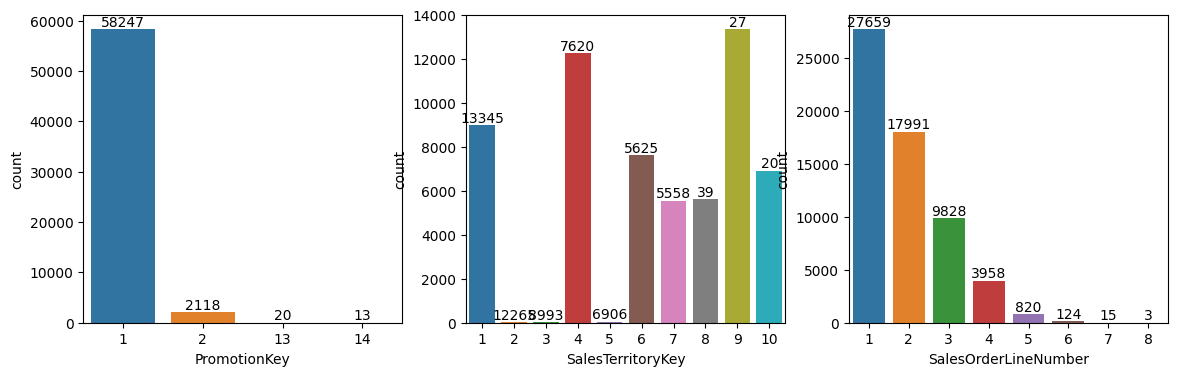

In [6]:
sales = pd.read_csv(myPath + 'cleaned/SALES_clean.csv', encoding='latin-1', \
    parse_dates=['OrderDate', 'DueDate', 'ShipDate'], infer_datetime_format=True)
df = sales
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = sns.countplot(data = df, ax=axes[0], x='PromotionKey')
abs_values = df['PromotionKey'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax = sns.countplot(data= df, ax=axes[1], x='SalesTerritoryKey')
abs_values = df['SalesTerritoryKey'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax = sns.countplot(ax=axes[2], x=df['SalesOrderLineNumber'])
abs_values = df['SalesOrderLineNumber'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values);

* Finalmente, concluimos con 9 columnas menos.
* Obtenemos el tipo de dato y número de caracteres de las columnas.
* Se identifican 5 llaves que contienen "Key" en su nombre.
    * ProductKey
    * CustomerKey
    * PromotionKey
    * CurrencyKey
    * SalesTerritoryKey

In [7]:
num_types = sales.dtypes.to_frame('dtypes')
min_col_len = sales.round(1).astype(str).apply(lambda s: s.str.len()).min().to_frame('min_length')
max_col_len = sales.round(1).astype(str).apply(lambda s: s.str.len()).max().to_frame('max_length')
min_max_value = sales.describe().T[['min','max']].round(1)
my_summary = pd.concat([num_types, min_col_len, max_col_len, min_max_value], axis=1)
sales_serie = sales['SalesOrderNumber'].str[2:]
# En SalesOrderNumber se ordenan los datos omitiendo 'CO'
min = 'CO'+ str(pd.to_numeric(sales_serie).min())
max = 'CO'+ str(pd.to_numeric(sales_serie).max())
dates = sales[['OrderDate','DueDate','ShipDate']]
my_summary.loc['SalesOrderNumber', ['min','max']] = [min, max]
my_summary.loc[['OrderDate','DueDate','ShipDate'], 'min'] = dates.min()
my_summary.loc[['OrderDate','DueDate','ShipDate'], 'max'] = dates.max()
my_summary

dtypes  min_length  max_length  \
ProductKey                     int64           3           3   
CustomerKey                    int64           5           5   
PromotionKey                   int64           1           2   
CurrencyKey                    int64           1           3   
SalesTerritoryKey              int64           1           2   
SalesOrderNumber              object           7           7   
SalesOrderLineNumber           int64           1           1   
UnitPrice                    float64           3           6   
ExtendedAmount               float64           3           6   
ProductStandardCost          float64           3           6   
TotalProductCost             float64           3           6   
SalesAmount                  float64           3           6   
TaxAmt                       float64           3           5   
Freight                      float64           3           4   
OrderDate             datetime64[ns]          10          10   
DueDate               datetime64[ns]          10          10   
ShipDate              datetime64[ns]          10          10   

                                      min                  max  
ProductKey                          214.0                606.0  
CustomerKey                       11000.0              29483.0  
PromotionKey                          1.0                 14.0  
CurrencyKey                           6.0                100.0  
SalesTerritoryKey                     1.0                 10.0  
SalesOrderNumber                  CO43697              CO75123  
SalesOrderLineNumber                  1.0                  8.0  
UnitPrice                             2.3               3578.3  
ExtendedAmount                        2.3               3578.3  
ProductStandardCost                   0.9               2171.3  
TotalProductCost                      0.9               2171.3  
SalesAmount                           2.3               3578.3  
TaxAmt                                0.2                286.3  
Freight                               0.1                 89.5  
OrderDate             2010-12-29 00:00:00  2014-01-28 00:00:00  
DueDate               2011-01-10 00:00:00  2014-02-09 00:00:00  
ShipDate              2011-01-05 00:00:00  2014-02-04 00:00:00

## 2. CUSTOMERS
Preguntas de la visualización general:
* ¿Es de utilidad una llave alterna de CustomerKey?
* ¿Qué información aporta NameStyle (solo existen valores falsos y nulos)?
* ¿Los primeros dígitos en AddressLine1 son el código postal?
* ¿Los números de teléfono con más de 10 dígitos añadieron al principio LADA?
* ¿CommuteDistance es la distancia de los clientes al punto de venta?

In [8]:
# cust.info() #18485 entradas, 29 columnas
cust.head(4)

CustomerKey  GeographyKey CustomerAlternateKey Title FirstName MiddleName  \
0        11000            26           AW00011000   NaN       Jon          V   
1        11001            37           AW00011001   NaN    Eugene          L   
2        11002            31           AW00011002   NaN     Ruben        NaN   
3         1002            31           AW00011002   NaN       NaN        NaN   

  LastName NameStyle   BirthDate MaritalStatus  ... EnglishOccupation  \
0     Yang     False  1971-10-06             M  ...      Professional   
1    Huang     False  1976-05-10             S  ...      Professional   
2   Torres     False  1971-02-09             M  ...               NaN   
3      NaN       NaN         NaN           NaN  ...      Professional   

  SpanishOccupation FrenchOccupation  HouseOwnerFlag  NumberCarsOwned  \
0       Profesional            Cadre             1.0              0.0   
1       Profesional            Cadre             0.0              1.0   
2               NaN            Cadre             1.0              1.0   
3       Profesional              NaN             NaN              NaN   

       AddressLine1 AddressLine2                Phone DateFirstPurchase  \
0   3761 N. 14th St          NaN  1 (11) 500 555-0162        2011-01-19   
1        2243 W St.          NaN  1 (11) 500 555-0110        2011-01-15   
2  5844 Linden Land          NaN  1 (11) 500 555-0184        2011-01-07   
3               NaN          NaN                  NaN               NaN   

  CommuteDistance  
0       1-2 Miles  
1       0-1 Miles  
2       2-5 Miles  
3             NaN  

[4 rows x 29 columns]

## Modificaciones en la tabla customers
* El cuarto registro en la tabla es un duplicado del tercero, con información complementaria. Hay que fusionar esa información.
* El 1 (11) en la columna Phone, parece ser información repetitiva. El formato de número deberá ser forzosamente XXX-XXX-XXXX, o bien 10 dígitos seguidos.
* La palabra "Miles" en la columna CommuteDistance es información redundante. Se debe eliminar. Además, contiene información categórica (0-1,2-5...), que puede ser mapeada con números para disminuir el volumen de datos.
* BirthDate y DateFirstPurchase deben guardarse en formato de fecha.
* Title contiene colamente 101 registros, Suffix 3 y AddressLine2 312. Considerando que el total de registros es de 18485, estas columnas tienen un porcentaje de datos del 0.54, 0.016 y 1.7%, respectivamente, por lo que las columnas no generarán conocimientos de interés y se eliminarán.

## Tabla products
* Se encontro que para la tabla Products_clean cuenta con 606 registros los cuales en su mayoria son de tipo object que en sql seria varchar.

In [9]:
#Cargamos archivo csv
products=pd.read_csv('/workspaces/Database-project/data/cleaned/Products_Clean.csv', encoding='utf-8')

In [10]:
types=products.dtypes.to_frame('dtypes')
min_col_len=products.round(1).astype(str).apply(lambda s: s.str.len()).min().to_frame('min_length')
max_col_len=products.round(1).astype(str).apply(lambda s: s.str.len()).max().to_frame('max_length')
min_max_value=products.describe().T[['min','max']].round(1)
my_summary=pd.concat([types,min_col_len,max_col_len,min_max_value], axis=1)
my_summary



dtypes  min_length  max_length  min     max
ProductKey               int64           1           3  1.0   606.0
ProductAlternateKey     object           7          10  NaN     NaN
ProductSubcategoryKey  float64           3           4  1.0    37.0
WeightUnitMeasureCode   object           3           3  NaN     NaN
SizeUnitMeasureCode     object           3           3  NaN     NaN
EnglishProductName      object           4          32  NaN     NaN
SpanishProductName      object           3          47  NaN     NaN
FrenchProductName       object           3          46  NaN     NaN
StandardCost           float64           3           6  0.9  2171.3
FinishedGoodsFlag         bool           4           5  NaN     NaN
Color                   object           3          12  NaN     NaN
SafetyStockLevel         int64           1           4  4.0  1000.0
ReorderPoint             int64           1           3  3.0   750.0
ListPrice              float64           3           6  2.3  3578.3
Size                    object           1           3  NaN     NaN
SizeRange               object           1           8  NaN     NaN
Weight                 float64           3           6  2.1  1050.0
DaysToManufacture        int64           1           1  0.0     4.0
ProductLine             object           2           3  NaN     NaN
DealerPrice            float64           3           6  1.4  2147.0
Class                   object           2           3  NaN     NaN
Style                   object           2           3  NaN     NaN
ModelName               object           3          27  NaN     NaN
EnglishDescription      object           3         221  NaN     NaN
FrenchDescription       object           3         269  NaN     NaN
StartDate               object          16          16  NaN     NaN
EndDate                 object           3          16  NaN     NaN
Status                  object           3           7  NaN     NaN

In [11]:
#Visulizamos una descripción de los datos que son numéricos
products.describe().T

count        mean         std     min       25%  \
ProductKey             606.0  303.500000  175.081410  1.0000  152.2500   
ProductSubcategoryKey  397.0   12.128463    9.423328  1.0000    2.0000   
StandardCost           395.0  434.265829  497.379884  0.8565   37.1209   
SafetyStockLevel       606.0  495.201320  364.007114  4.0000  100.0000   
ReorderPoint           606.0  371.400990  273.005336  3.0000   75.0000   
ListPrice              395.0  747.661762  838.708451  2.2900   69.9900   
Weight                 282.0   56.193227  158.000652  2.1200    2.6800   
DaysToManufacture      606.0    1.201320    1.508893  0.0000    0.0000   
DealerPrice            395.0  448.597060  503.225071  1.3740   41.9940   

                            50%        75%        max  
ProductKey             303.5000   454.7500   606.0000  
ProductSubcategoryKey   13.0000    16.0000    37.0000  
StandardCost           204.6251   660.9142  2171.2942  
SafetyStockLevel       500.0000  1000.0000  1000.0000  
ReorderPoint           375.0000   750.0000   750.0000  
ListPrice              364.0900  1204.3248  3578.2700  
Weight                  15.4200    24.1300  1050.0000  
DaysToManufacture        1.0000     1.0000     4.0000  
DealerPrice            218.4540   722.5949  2146.9620

In [12]:
products.head(7)

ProductKey ProductAlternateKey  ProductSubcategoryKey  \
0           1             AR-5381                    NaN   
1           2             BA-8327                    NaN   
2           3             BE-2349                    NaN   
3           4             BE-2908                    NaN   
4           5             BL-2036                    NaN   
5           6             CA-5965                    NaN   
6           7             CA-6738                    NaN   

  WeightUnitMeasureCode SizeUnitMeasureCode     EnglishProductName  \
0                   NaN                 NaN        Adjustable Race   
1                   NaN                 NaN           Bearing Ball   
2                   NaN                 NaN        BB Ball Bearing   
3                   NaN                 NaN  Headset Ball Bearings   
4                   NaN                 NaN                  Blade   
5                   NaN                 NaN            LL Crankarm   
6                   NaN                 NaN            ML Crankarm   

  SpanishProductName FrenchProductName  StandardCost  FinishedGoodsFlag  ...  \
0                NaN               NaN           NaN              False  ...   
1                NaN               NaN           NaN              False  ...   
2                NaN               NaN           NaN              False  ...   
3                NaN               NaN           NaN              False  ...   
4                NaN               NaN           NaN              False  ...   
5                NaN               NaN           NaN              False  ...   
6                NaN               NaN           NaN              False  ...   

  ProductLine  DealerPrice  Class  Style ModelName EnglishDescription  \
0         NaN          NaN    NaN    NaN       NaN                NaN   
1         NaN          NaN    NaN    NaN       NaN                NaN   
2         NaN          NaN    NaN    NaN       NaN                NaN   
3         NaN          NaN    NaN    NaN       NaN                NaN   
4         NaN          NaN    NaN    NaN       NaN                NaN   
5         NaN          NaN     L     NaN       NaN                NaN   
6         NaN          NaN     M     NaN       NaN                NaN   

   FrenchDescription         StartDate EndDate   Status  
0                NaN  01/07/2003 00:00     NaN  Current  
1                NaN  01/07/2003 00:00     NaN  Current  
2                NaN  01/07/2003 00:00     NaN  Current  
3                NaN  01/07/2003 00:00     NaN  Current  
4                NaN  01/07/2003 00:00     NaN  Current  
5                NaN  01/07/2003 00:00     NaN  Current  
6                NaN  01/07/2003 00:00     NaN  Current  

[7 rows x 28 columns]

In [13]:
#observamos una muestra de 7 datos
products.sample(7)

ProductKey ProductAlternateKey  ProductSubcategoryKey  \
58           59             HN-1420                    NaN   
547         548             PD-T852                   13.0   
175         176             PB-6109                    NaN   
595         596          BK-M18B-40                    1.0   
234         235           LJ-0192-X                   21.0   
226         227           LJ-0192-S                   21.0   
471         472           VE-C304-M                   25.0   

    WeightUnitMeasureCode SizeUnitMeasureCode           EnglishProductName  \
58                    NaN                 NaN                    Hex Nut 8   
547                   NaN                 NaN                Touring Pedal   
175                   NaN                 NaN                   Pinch Bolt   
595                   LB                  CM        Mountain-500 Black, 40   
234                   NaN                 NaN  Long-Sleeve Logo Jersey, XL   
226                   NaN                 NaN   Long-Sleeve Logo Jersey, S   
471                   NaN                 NaN              Classic Vest, M   

                         SpanishProductName  \
58                                      NaN   
547                          Pedal de paseo   
175                                     NaN   
595                 Montaña: 500, negra, 40   
234  Jersey con logotipo de manga larga, SG   
226   Jersey con logotipo de manga larga, P   
471                     Camiseta clásica, M   

                                FrenchProductName  StandardCost  \
58                                            NaN           NaN   
547                   Pédale de vélo de randonnée       35.9596   
175                                           NaN           NaN   
595                              VTT 500 noir, 40      294.5797   
234  Maillot manches longues avec logo, taille XL       31.7244   
226   Maillot manches longues avec logo, taille S       29.0807   
471                     Veste classique, taille M       23.7490   

     FinishedGoodsFlag  ... ProductLine  DealerPrice  Class  Style  \
58               False  ...         NaN          NaN    NaN    NaN   
547               True  ...          T       48.5940    NaN    NaN   
175              False  ...         NaN          NaN    NaN    NaN   
595               True  ...          M      323.9940     L      U    
234               True  ...          S       28.8404    NaN     U    
226               True  ...          S       28.8404    NaN     U    
471               True  ...          S       38.1000    NaN     U    

                   ModelName  \
58                       NaN   
547            Touring Pedal   
175                      NaN   
595             Mountain-500   
234  Long-Sleeve Logo Jersey   
226  Long-Sleeve Logo Jersey   
471             Classic Vest   

                                    EnglishDescription  \
58                                                 NaN   
547                 A stable pedal for all-day riding.   
175                                                NaN   
595  Suitable for any type of riding, on or off-roa...   
234  Unisex long-sleeve AWC logo microfiber cycling...   
226  Unisex long-sleeve AWC logo microfiber cycling...   
471  Light-weight, wind-resistant, packs to fit int...   

                                     FrenchDescription         StartDate  \
58                                                 NaN  01/07/2003 00:00   
547                  Pédale stable pour longs trajets.  01/07/2013 00:00   
175                                                NaN  01/07/2003 00:00   
595  Adapté à tous les usages, sur route ou tout-te...  01/07/2013 00:00   
234  Maillot de cycliste en microfibre avec le logo...  01/07/2011 00:00   
226  Maillot de cycliste en microfibre avec le logo...  01/07/2012 00:00   
471  Sacs légers et résistants au vent ; tiennent d...  01/07/2013 00:00   

              EndDate   Status  
58                NaN  Current  
547        

## Analizando los datos
#### Se observa que la tabla products_clean la cual contiene un gran numero de datos nulos en practicamente todas las columnas asi mismo otras observaciones como: 
* Las fechas contienen una datesatamp que no es necesaria para el analisis.
* La columna FishedGoodsFlag contiene un valor que podemos tomar como indicador de que el producto sea un producto terminado cuando el valor sea True o False cuando no, de igual forma que pueda ser que se encuentre catalogado cuando el valor sea True o False cuando no.
##### FinishedGoodsFlag: Finished Goods Flag es un término que se refiere a los productos terminados que han completado el proceso de fabricación pero que aún no se han vendido o distribuido al usuario final. Es un indicador que puede usarse para clasificar los productos en el inventario de una empresa.

In [14]:
#observamos los datos nulos dentro de nuestra tabla
products.isnull().sum()

ProductKey                 0
ProductAlternateKey        0
ProductSubcategoryKey    209
WeightUnitMeasureCode    324
SizeUnitMeasureCode      353
EnglishProductName         0
SpanishProductName       287
FrenchProductName        287
StandardCost             211
FinishedGoodsFlag          0
Color                    254
SafetyStockLevel           0
ReorderPoint               0
ListPrice                211
Size                     307
SizeRange                307
Weight                   324
DaysToManufacture          0
ProductLine              226
DealerPrice              211
Class                    276
Style                    305
ModelName                209
EnglishDescription       210
FrenchDescription        210
StartDate                  0
EndDate                  406
Status                   200
dtype: int64

In [15]:
#Procedemos a eliminar timesatam de las columnas StartDate y EndDate
products['StartDate']=products['StartDate'].str[:10]
products['EndDate']=products['EndDate'].str[:10]
products.sample(9)

ProductKey ProductAlternateKey  ProductSubcategoryKey  \
278         279          FR-R38B-44                   14.0   
546         547             PD-R853                   13.0   
68           69             HN-5811                    NaN   
405         406             HB-R720                    4.0   
113         114             LJ-7162                    NaN   
570         571          BK-T18Y-58                    3.0   
187         188             SA-M237                    NaN   
471         472           VE-C304-M                   25.0   
219         220           HL-U509-B                   31.0   

    WeightUnitMeasureCode SizeUnitMeasureCode         EnglishProductName  \
278                   LB                  CM   LL Road Frame - Black, 44   
546                   G                   NaN              HL Road Pedal   
68                    NaN                 NaN                 Hex Nut 20   
405                   NaN                 NaN         ML Road Handlebars   
113                   NaN                 NaN        Thin-Jam Lock Nut 8   
570                   LB                  CM     Touring-3000 Yellow, 58   
187                   NaN                 NaN  ML Mountain Seat Assembly   
471                   NaN                 NaN            Classic Vest, M   
219                   NaN                 NaN     Sport-100 Helmet, Blue   

                    SpanishProductName                     FrenchProductName  \
278  Cuadro de carretera GB: negro, 44  Cadre de vélo de route LL - noir, 44   
546              Pedal de carretera GA            Pédale de vélo de route HL   
68                                 NaN                                   NaN   
405           Manillar de carretera GM          Poignées de vélo de route ML   
113                                NaN                                   NaN   
570          Paseo: 3000, amarilla, 58      Vélo de randonnée 3000 jaune, 58   
187                                NaN                                   NaN   
471                Camiseta clásica, M             Veste classique, taille M   
219         Casco deportivo: 100, azul                Casque sport 100, bleu   

     StandardCost  FinishedGoodsFlag  ... ProductLine  DealerPrice  Class  \
278      176.1997               True  ...          R      178.5808     L    
546       35.9596               True  ...          R       48.5940     H    
68            NaN              False  ...         NaN          NaN    NaN   
405       27.4925               True  ...          R       37.1520     M    
113           NaN              False  ...         NaN          NaN    NaN   
570      461.4448               True  ...          T      445.4100     L    
187           NaN              False  ...         NaN          NaN     M    
471       23.7490               True  ...          S       38.1000    NaN   
219       12.0278               True  ...          S       20.1865    NaN   

     Style           ModelName  \
278     U        LL Road Frame   
546    NaN       HL Road Pedal   
68     NaN                 NaN   
405    NaN  ML Road Handlebars   
113    NaN                 NaN   
570     U         Touring-3000   
187    NaN                 NaN   
471     U         Classic Vest   
219    NaN           Sport-100   

                                    EnglishDescription  \
278  The LL Frame provides a safe comfortable ride,...   
546  Top-of-the-line clipless pedals with adjustabl...   
68                                                 NaN   
405  Anatomically shaped aluminum tube bar will sui...   
113                                                NaN   
570  All-occasion value bike with our basic comfort...   
187                                                NaN   
471  Light-weight, wind-resistant, packs to fit int...   
219  Universal fit, well-vented, lightweight , snap...   

                                     FrenchDescription   StartDate  \
278  Le cadre LL en aluminium offre une conduite co...  01/

In [16]:
#Creamos un set donde FinishedGoodsFlag sea True y otro donde sea False ademas un set para
# status current
products_true=products[products['FinishedGoodsFlag']==True]
products_false=products[products['FinishedGoodsFlag']==False]
products_true_current=products_true[products_true['Status']=='Current']

In [17]:
products_true.sample(5)

ProductKey ProductAlternateKey  ProductSubcategoryKey  \
600         601             BB-7421                    5.0   
333         334          BK-R50B-60                    2.0   
425         426          FR-M63B-40                   12.0   
503         504          FR-T67U-58                   16.0   
328         329          BK-R50R-48                    2.0   

    WeightUnitMeasureCode SizeUnitMeasureCode             EnglishProductName  \
600                   G                   NaN              LL Bottom Bracket   
333                   LB                  CM              Road-650 Black, 60   
425                   LB                  CM   ML Mountain Frame - Black, 40   
503                   LB                  CM     LL Touring Frame - Blue, 58   
328                   LB                  CM                Road-650 Red, 48   

               SpanishProductName                         FrenchProductName  \
600            Eje de pedalier GB                        Axe de pédalier LL   
333     Carretera: 650, negra, 60                Vélo de route 650 noir, 60   
425                           NaN                                       NaN   
503  Cuadro de paseo GB: azul, 58  Cadre de vélo de randonnée LL - bleu, 58   
328      Carretera: 650, roja, 48               Vélo de route 650 rouge, 48   

     StandardCost  FinishedGoodsFlag  ... ProductLine  DealerPrice  Class  \
600       23.9716               True  ...         NaN      32.3940     L    
333      413.1463               True  ...          R      419.4589     L    
425      185.8193               True  ...          M      209.2560     M    
503      199.8519               True  ...          T      200.0520     L    
328      486.7066               True  ...          R      469.7940     L    

     Style          ModelName  \
600    NaN  LL Bottom Bracket   
333     U            Road-650   
425     U   ML Mountain Frame   
503     U    LL Touring Frame   
328     U            Road-650   

                                    EnglishDescription  \
600                                    Chromoly steel.   
333  Value-priced bike with many features of our to...   
425  The ML frame is a heat-treated aluminum frame ...   
503  Lightweight butted aluminum frame provides a m...   
328  Value-priced bike with many features of our to...   

                                     FrenchDescription   StartDate  \
600                                      Acier chromé.  01/07/2013   
333  Vélo très séduisant comportant de nombreuses c...  01/07/2011   
425  Le cadre ML est un cadre en aluminium traité à...  01/07/2012   
503  Cadre renforcé léger pour une position plus dr...  01/07/2013   
328  Vélo très séduisant comportant de nombreuses c...  01/07/2012   

        EndDate   Status  
600         NaN  Current  
333  28/12/2007      NaN  
425  27/12/2008      NaN  
503         NaN  Current  
328  27/12/2008      NaN  

[5 rows x 28 columns]

## Limpieza de datos
##### Se comienza con limpieza de tablas que no aportan informacion relevante para el analisis, ademas de normalizacion y eliminacion de datos y columnas con datos nulos.
* ¿Que tablas no aportan informacion relevante para el analisis?
* ¿Que tablas tienen datos nulos?
* ¿Que tablas tienen datos duplicados (Llaves primarias)?
* ¿Que tablas tienen datos duplicados (Llaves foraneas)?
* ¿Los tipos de datos por columna son los correctos?

In [26]:
#creamos un set donde empezarmeos a limpiar los datos
products_clean_1=products
products_clean_1=pd.DataFrame(products_clean_1)


In [27]:
#Verificamos los tipos de datos de cada elemento de cada columna
tipos=products_clean_1.dtypes
for i in products_clean_1.columns:
    for j in products_clean_1[i]:
        if type(j)!=tipos[i]:
            erroneos=products_clean_1[i]
            print(erroneos)

0         AR-5381
1         BA-8327
2         BE-2349
3         BE-2908
4         BL-2036
          ...    
601       BB-8107
602       BB-9108
603    BK-R19B-44
604    BK-R19B-48
605    BK-R19B-52
Name: ProductAlternateKey, Length: 606, dtype: object
0         AR-5381
1         BA-8327
2         BE-2349
3         BE-2908
4         BL-2036
          ...    
601       BB-8107
602       BB-9108
603    BK-R19B-44
604    BK-R19B-48
605    BK-R19B-52
Name: ProductAlternateKey, Length: 606, dtype: object
0         AR-5381
1         BA-8327
2         BE-2349
3         BE-2908
4         BL-2036
          ...    
601       BB-8107
602       BB-9108
603    BK-R19B-44
604    BK-R19B-48
605    BK-R19B-52
Name: ProductAlternateKey, Length: 606, dtype: object
0         AR-5381
1         BA-8327
2         BE-2349
3         BE-2908
4         BL-2036
          ...    
601       BB-8107
602       BB-9108
603    BK-R19B-44
604    BK-R19B-48
605    BK-R19B-52
Name: ProductAlternateKey, Length: 606, dtype:

## Datos separados
#### Una vez separados los datos podemos observar mejor datos como:
* Promedios
* Minimos
* Maximos
#### Ahora podemos graficar datos de interes asi mismo podemos identificar el signifiacante numero de datos faltantes en cada uno de los sets

In [20]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es True
pd.DataFrame(products_true.isnull().sum()).T

ProductKey  ProductAlternateKey  ProductSubcategoryKey  \
0           0                    0                      0   

   WeightUnitMeasureCode  SizeUnitMeasureCode  EnglishProductName  \
0                    122                  144                   0   

   SpanishProductName  FrenchProductName  StandardCost  FinishedGoodsFlag  \
0                  78                 78             2                  0   

   ...  ProductLine  DealerPrice  Class  Style  ModelName  EnglishDescription  \
0  ...           17            2     85     96          0                   1   

   FrenchDescription  StartDate  EndDate  Status  
0                  1          0      197     200  

[1 rows x 28 columns]

In [21]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es False
pd.DataFrame(products_false.isnull().sum()).T

ProductKey  ProductAlternateKey  ProductSubcategoryKey  \
0           0                    0                    209   

   WeightUnitMeasureCode  SizeUnitMeasureCode  EnglishProductName  \
0                    202                  209                   0   

   SpanishProductName  FrenchProductName  StandardCost  FinishedGoodsFlag  \
0                 209                209           209                  0   

   ...  ProductLine  DealerPrice  Class  Style  ModelName  EnglishDescription  \
0  ...          209          209    191    209        209                 209   

   FrenchDescription  StartDate  EndDate  Status  
0                209          0      209       0  

[1 rows x 28 columns]

In [22]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es True y Status es Current
pd.DataFrame(products_true_current.isnull().sum()).T

ProductKey  ProductAlternateKey  ProductSubcategoryKey  \
0           0                    0                      0   

   WeightUnitMeasureCode  SizeUnitMeasureCode  EnglishProductName  \
0                     61                   77                   0   

   SpanishProductName  FrenchProductName  StandardCost  FinishedGoodsFlag  \
0                  39                 39             2                  0   

   ...  ProductLine  DealerPrice  Class  Style  ModelName  EnglishDescription  \
0  ...           11            2     42     57          0                   1   

   FrenchDescription  StartDate  EndDate  Status  
0                  1          0      197       0  

[1 rows x 28 columns]

In [23]:
#Se puede observar un  mejor calculo de los datos sin nulos
products_true.describe().T

count        mean         std       min       25%  \
ProductKey             397.0  408.000000  114.748275  210.0000  309.0000   
ProductSubcategoryKey  397.0   12.128463    9.423328    1.0000    2.0000   
StandardCost           395.0  434.265829  497.379884    0.8565   37.1209   
SafetyStockLevel       397.0  282.851385  220.417534    4.0000  100.0000   
ReorderPoint           397.0  212.138539  165.313151    3.0000   75.0000   
ListPrice              395.0  747.661762  838.708451    2.2900   69.9900   
Weight                 275.0   46.569055  147.796111    2.1200    2.5000   
DaysToManufacture      397.0    1.765743    1.578913    0.0000    1.0000   
DealerPrice            395.0  448.597060  503.225071    1.3740   41.9940   

                            50%        75%        max  
ProductKey             408.0000   507.0000   606.0000  
ProductSubcategoryKey   13.0000    16.0000    37.0000  
StandardCost           204.6251   660.9142  2171.2942  
SafetyStockLevel       500.0000   500.0000   500.0000  
ReorderPoint           375.0000   375.0000   375.0000  
ListPrice              364.0900  1204.3248  3578.2700  
Weight                  15.1300    23.7700  1050.0000  
DaysToManufacture        1.0000     4.0000     4.0000  
DealerPrice            218.4540   722.5949  2146.9620

### ¿Que podemos observar de los datos?

Text(0.5, 1.0, 'Status')

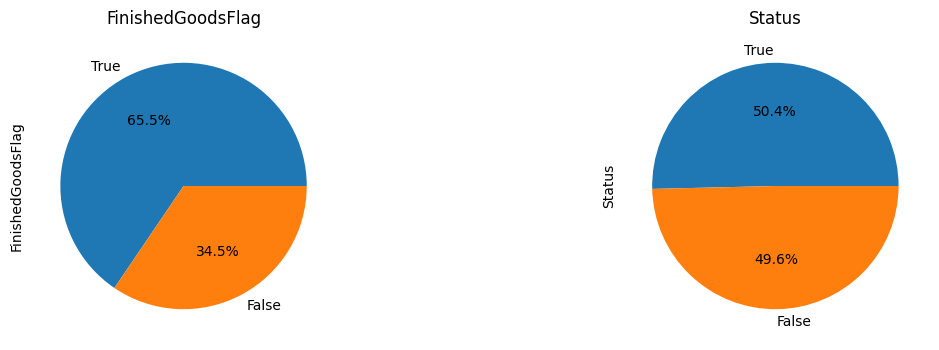

In [24]:
#Se crean dos graficos con los datos de FinishedGoodsFlag y Status
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax = products['FinishedGoodsFlag'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0])
ax.set_title('FinishedGoodsFlag')

ax=products_true['Status'].isnull().value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1])
ax.set_title('Status')




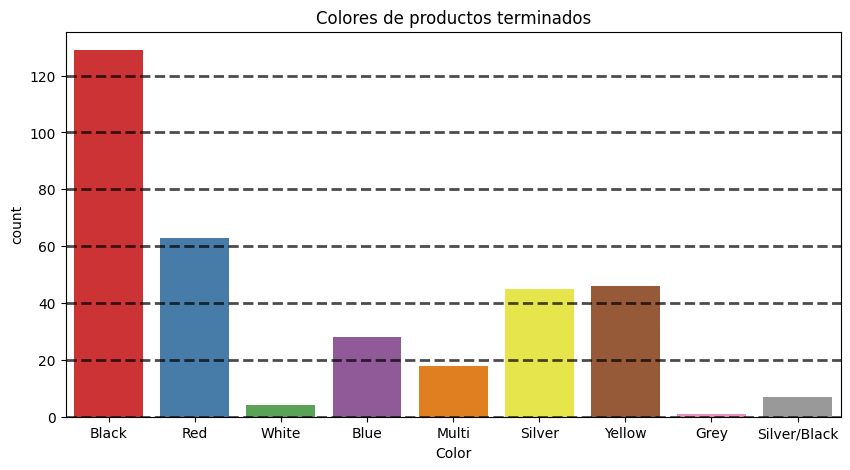

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(x='Color',data=products_true,palette='Set1')
plt.title('Colores de productos terminados')
plt.grid(color='black', linestyle='--',linewidth=2, axis='y', alpha=0.7)
plt.show()